In [17]:
DATA_DIR = '../../data/'

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import gensim
import zipfile

from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

In [19]:
from tqdm.notebook import tqdm

In [20]:
import tqdm as tqdm_

In [21]:
tqdm_.__version__

'4.43.0'

In [22]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

Срок выполнения задания – до 5 мая включительно.

Отчет высылается по почте Зуеву Кириллу на адрес  kir2207@list.ru

В качестве темы письма указать:  «КЛ ДЗ № 3, ФИО»

Отчет должен быть в виде отдельного текста, код программы включается как приложение.

# Задание С.  (8-9 баллов)
Для нескольких (5-9) достаточно частотных слов русского языка и семантически связанных с ними слов (синонимов, гипонимов, гиперонимов, антонимов и др.), подобранных из некоторого лингвистического ресурса, в частности, 
* тезауруса РуТез:  http://www.labinform.ru/pub/ruthes/index.htm  или
* системы КроссЛексика:    http://www.xl.gelbukh.com 

исследовать соотношение их векторных представлений на базе предобученной модели Word2Vec и/или FastText, взятой, например, из ресурса Rusvectores: http://rusvectores.org/ru/models/ или из библиотеки Gensim: https://radimrehurek.com/gensim/models/word2vec.html.
Определить, есть ли какие-либо закономерности в косинусном расстоянии между  лексически (тезаурусно) связанными  словами? Подобны ли расстояния между парами связанных слов? Выполняются ли алгебраические зависимости?
Отчет:  описание использованной модели и проведенных экспериментов, выявленные закономерности (если таковые обнаружились); выводы.

# Поиск частотных слов

По данным "Нового частотного словаря русской лексики" О.Н. Ляшевской, С.А. Шарова: http://dict.ruslang.ru/freq.php

In [23]:
with open(DATA_DIR+'freqrnc_readme.txt', 'r', encoding='cp1251') as f:
    txt = f.read()

print(txt)

Информация о файле freqrnc2011.csv (кодировка UTF8, разрыв строк UNIX, разделитель полей табуляция).

Электронная версия издания:
О. Н. Ляшевская, С. А. Шаров, Частотный словарь современного русского языка (на материалах Национального корпуса русского языка). М.: Азбуковник, 2009. http://dict.ruslang.ru/freq.php

Алфавитный список лемм (общая лекика; имена собственные и аббревиатуры)

Список приводится в алфавитном порядке. Указаны:
Lemma – лемма (исходная форма слова),
PoS – часть речи,
Freq(ipm) – частота леммы на 1 миллион употреблений,
R (range) – число сегментов корпуса, в которых встретилась лемма (из 100 возможных),
D – коэффициент Жуйана,
Doc – число текстов, в которых встретилась лемма.

Словарь создан на основе современного подкорпуса Основного корпуса и Устного корпуса НКРЯ (1950-2007), общий объем 92 млн. словоупотреблений.

Более подробная информация - во "Введении к словарю" http://dict.ruslang.ru/freq.pdf.

При использовании ресурса просьба ссылаться на первоисточник:
О.

Загрузим файл

In [24]:
freq_words_ds = pd.read_csv(DATA_DIR+'freqrnc2011.csv', sep='\t')
print(freq_words_ds.shape)
freq_words_ds.head()

(52138, 6)


,Lemma,PoS,Freq(ipm),R,D,Doc
0,а,conj,8198.0,100,97,32332
1,а,intj,19.8,99,90,757
2,а,part,6.1,59,79,128
3,а,s,2.7,59,85,160
4,аа,intj,1.5,47,80,68


Отсортируем слова частоте употребления

In [25]:
freq_words_ds = freq_words_ds.sort_values('Freq(ipm)', ascending=False)
freq_words_ds.head()

,Lemma,PoS,Freq(ipm),R,D,Doc
13824,и,conj,35801.8,100,99,37704
3710,в,pr,31374.2,100,98,37865
23328,не,part,18028.0,100,97,33999
22019,на,pr,15867.3,100,98,36748
51957,я,spro,12684.4,100,95,17116


Самые частые слова - союзы, приставки, частицы. Отсечём их. Оставим только существительные и глаголы

In [26]:
freq_words_ds = freq_words_ds[freq_words_ds['PoS'].isin(['s','v'])]

/home/egor/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


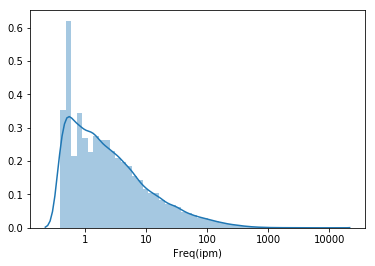

In [27]:
sns.distplot(np.log(freq_words_ds['Freq(ipm)']))
xticks = [1, 10, 100, 1000, 10000]
plt.xticks(np.log(xticks), xticks)
plt.show()

В среднем слова употребляются 1 раз на милион. Посмотрим достаточно частотные слова, которые употребляются 100 раз на милион (1 раз на 10т. употреблений)

In [28]:
freq_words_ds[freq_words_ds['Freq(ipm)']>100].sort_values('Freq(ipm)',ascending=True).head(15)

,Lemma,PoS,Freq(ipm),R,D,Doc
29744,передача,s,100.1,100,91,3452
20785,механизм,s,100.1,100,89,3778
44017,столица,s,100.2,100,92,4009
20811,мешать,v,100.4,100,97,3455
29829,перейти,v,100.5,100,98,4037
38583,рассматривать,v,100.6,100,91,3959
31071,поведение,s,100.7,100,90,2962
20207,мастер,s,100.8,100,94,2885
7246,газ,s,101.0,100,90,2730
36540,простить,v,101.1,100,93,2270


## Ищем похожие слова

In [29]:
words_dict = {}

Данные по синонимам, гипонимам и гиперонимам берём из тезауруса РуТез, по антонимам - из системы КроссЛексика

"механизм": http://www.labinform.ru/pub/ruthes/te/13/008/142187.htm

In [30]:
wd = {'synonyms':{"автомат", "аппарат", "робот", "механизм", "машина", "установка", "прибор", "устройство", "приспособление"},
      'hyponyms':{"агрегат","комбайн","узел","амортизатор","антенна","сепаратор","смеситель"},
      'hyperonyms':{"приспособление","инструмент","процедура","строение","структура"},
      "antonyms":set()
     }
words_dict["механизм"] = wd

"столица": http://www.labinform.ru/pub/ruthes/te/18/031/112142.htm

In [31]:
wd = {'synonyms':{"главный город","стольный","административная столица","столичный город"},
      'hyponyms':{"ибиджан","абу-даби","будапешт","гавана","дублин","каир","хельсинки","тегеран","токио","москва"},
      'hyperonyms':{"город","административный центр"},
      "antonyms":{"провинция"}
     }
words_dict["столица"] = wd

"мешать" http://www.labinform.ru/pub/ruthes/te/13/008/142198.htm

In [32]:
wd = {'synonyms':{"воспрепятствовать","помешать","препятствовать","смешать","служить помехой","помешивать","смешиваться"},
      'hyponyms':{"задержать","затруднить","парализовать","путать","примешать","перемешать","размешать","дергать","тормозить","сорвать"},
      'hyperonyms':{"влиять","воздействовать","переместить","соединить в одно целое"},
      'antonyms':{"возбуждать","деблокировать","действовать","настраивать",'облегчать','помогать'}
     }
words_dict["мешать"] = wd

"рассматривать" http://www.labinform.ru/pub/ruthes/te/17/004/151383.htm

In [33]:
wd = {'synonyms':{"дорассмотреть","проанализировать","разбирать","разобрать","разлядеть","разглядывать","расценивать","","",""},
      'hyponyms':{"анализ","вычислить","критиковать","обозреть","засмотреться","любоваться","смотреться","рефлексия","экспертиза","рассудить"},
      'hyperonyms':{"определить","выяснить","оценить","дать оценку","осмотреть","оглядеть"},
      "antonyms":{"синтезировать"}
     }
words_dict["рассматривать"] = wd

"поведение" http://www.labinform.ru/pub/ruthes/te/16/009/147275.htm

In [34]:
wd = {'synonyms':{"вести себя","линия поведения","поведенческий","повести себя"},
      'hyponyms':{"аскетизм","бесстрашие","геройство","привычка","своеволие","эпатаж","подвижничество","ласкать","скупиться","смелость"},
      'hyperonyms':{"действие","целенаправленное действие"},
      "antonyms":set()
     }
words_dict["поведение"] = wd

"мастер" http://www.labinform.ru/pub/ruthes/te/13/003/141967.htm

In [35]:
wd = {'synonyms':{"мастер спорта","мастер участка","золотые руки","искусница","мастак","мастерица","умелец","умелица","артист в своем деле"},
      'hyponyms':{"визажист","обувной мастер","ювелир","стилист","кулинар","снайпер","мастер-виртуоз","ремесленник","кустарь","ювелир"},
      'hyperonyms':{"спортсмен","спортивное звание","работник","административная должность","руководитель","человек","работник промышленности"},
      "antonyms":{'дилетант','ломастер','неспециалист','неумеха'}
     }
words_dict["мастер"] = wd

"газ" http://www.labinform.ru/pub/ruthes/te/04/001/102252.htm

In [36]:
wd = {'synonyms':{"газовый","газообразный","газообразный компонент","газик","автомобиль газ","газообразное топливо","голубое топливо","горючий газ"},
      'hyponyms':{"бытовой газ","попутный газ","природный газ","азот","аммиак","бутан","автомобиль 'газель'","фтор","хлор","плазма"},
      'hyperonyms':{"газообразное вещество","органическое топливо","вещество","автомобиль","марка автомобиля"},
      "antonyms":set()
     }
words_dict["газ"] = wd

"бабушка" http://www.labinform.ru/pub/ruthes/te/02/001/100711.htm

In [37]:
wd = {'synonyms':{"бабка","бабуля","мама отца","бабулька","старуха","божий одуванчик","мать матери","бабуся"},
      'hyponyms':{"прабабка","старая карга"},
      'hyperonyms':{"родственница","пожилая женщина","престарелый гражданин"}
     }
words_dict["бабушка"] = wd

"высота" http://www.labinform.ru/pub/ruthes/te/03/024/135660.htm

In [38]:
wd = {'synonyms':{"вышина","высотный параметр","высота звука","апофеоз","венец","верх","зенит","разгар","кульминация","высотка"},
      'hyponyms':{"рост человека","эшелон полета","высокий по звуку","звездный час","расцвет","процветание","гвоздь программы",},
      'hyperonyms':{"пик","степень","характеристика звука","расстояние","возвышенность","пространство","протяженность"},
      "antonyms":{'низина'}
     }
words_dict["высота"] = wd

"собрать" http://www.labinform.ru/pub/ruthes/te/18/019/153456.htm

In [39]:
wd = {'synonyms':{"насобирать","пособирать","собирание","собирать","напрягать","напрячь","поднажать","пособирать","убрать",},
      'hyponyms':{"копить","накапливать","набрать","организовать","подобрать","составить","вслушаться","всмотреться","обобрать","перенапрячься"},
      'hyperonyms':{"прикрепить","приделать","соединить","создать","снять","пытаться","стараться"},
      "antonyms":{'израсходовать','надеть','назначить','натянуть','промотать','разбросать','развести','разобрать','растащить'}
     }
words_dict["собрать"] = wd

# Получаем векторы слов

Загрузка Word2Vec модели

In [40]:
def get_model(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as archive:
        stream = archive.open('model.bin')
        model = gensim.models.KeyedVectors.load_word2vec_format(
            stream, binary=True)
    return model

Получение вектора для слова с автоматической подстановкой части речи

In [41]:
def get_wordvector(word):
    for sufx in ['NOUN','VERB', 'ADJ']:
        w = f"{word}_{sufx}"
        if w in model.wv:
            return model.wv[w]
    else:
        print(f'{word} not in model')
        return None

Модель загружена с сайта https://rusvectores.org/ru/models/ под идентификатором ruscorpora_upos_cbow_300_20_2019

Загрузим модель Word2Vec

In [42]:
model = get_model(DATA_DIR+'180.zip')

/home/egor/.local/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Получим список всех слов, указанных в качестве синонимов, антонимов и т.п.

In [43]:
words = [w_ for bw, wd in words_dict.items() for w_ in [bw]+[w for ws in wd.values() for w in ws]]

Вычислим векторы этих слов

In [44]:
wvs_dict = {w:get_wordvector(w) for w in words if ' ' not in w}
wvs_dict = {w:wv for w, wv in wvs_dict.items() if wv is not None }

токио not in model
хельсинки not in model
абу-даби not in model
гавана not in model
дублин not in model
ибиджан not in model
деблокировать not in model
 not in model
разлядеть not in model
дорассмотреть not in model
умелица not in model
мастер-виртуоз not in model
ломастер not in model
пособирать not in model
перенапрячься not in model


/home/egor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.
/home/egor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


# Гипотеза 1

Являются ли векторы синонимичных слов более похожими друг на друга, чем векторы несвязанных слов? Выполняется ли такая зависимость для других типов связей?

Рассчитаем косинусные расстояния между векторами

In [45]:
dists = {}
for w1 in words:
    for w2 in words:
        if w1==w2:
            continue
        if w1 in wvs_dict and w2 in wvs_dict:
            cs = cosine_distances([wvs_dict[w1], wvs_dict[w2]])[0,1]
            w = tuple([w1,w2])#tuple(sorted([w1,w2]))
            dists[w] = cs
print(f'Num of distances: {len(dists)}')

Num of distances: 31152


Составим датасет из рассчитанных расстояний

In [46]:
dists_ds = pd.Series(dists).reset_index()
dists_ds.columns = ['w1','w2','dist']

Выделим синонимичные пары. Будем считать, что отношение синонимичности транзитивно, т.е. если A синоним B, B синоним C, то и A - синоним C

In [47]:
synonyms_list = [[k]+list(vs['synonyms']) for k,vs in words_dict.items()]

is_syn = []
for ridx, row in tqdm(dists_ds.iterrows(), total=len(dists_ds)):
    if any([row['w1'] in syns and row['w2'] in syns for syns in synonyms_list]):
        is_syn.append(True)
    else:
        is_syn.append(False)

dists_ds['is_synonyms'] = is_syn

Выделим отношения гипонимии, гиперонимии, антонимии. Также отдельно посчитаем транзитивные гипонимию и гиперонимию (напр. A - гипоним B, B - гипоним C, будем считать, что A - гипоним 2ой степени для C)

In [48]:
for f in ['is_hyponym', 'is_hyperonym', 'is_hyponym2', 'is_hyperonym2', 'is_antonym']:
    dists_ds[f] = False

for w, wd in words_dict.items():
    for w_hypon in wd['hyponyms']:
        dists_ds.loc[(dists_ds['w1']==w_hypon)&(dists_ds['w2']==w), 'is_hyponym'] = True
        dists_ds.loc[(dists_ds['w1']==w)&(dists_ds['w2']==w_hypon), 'is_hyperonym'] = True
        
    for w_hyper in wd['hyperonyms']:
        dists_ds.loc[(dists_ds['w1']==w_hyper)&(dists_ds['w2']==w), 'is_hyperonym'] = True
        dists_ds.loc[(dists_ds['w1']==w)&(dists_ds['w2']==w_hyper), 'is_hyponym'] = True
        
    for w_hypon in wd['hyponyms']:
        for w_hyper in wd['hyperonyms']:
            dists_ds.loc[(dists_ds['w1']==w_hypon)&(dists_ds['w2']==w_hyper), 'is_hyponym2'] = True
            dists_ds.loc[(dists_ds['w1']==w_hyper)&(dists_ds['w2']==w_hypon), 'is_hyperonym2'] = True
    
    for w_syn in [w]+list(wd['synonyms']):
        for w_ant in wd.get('antonyms',[]):
            #dists_ds.loc[(dists_ds['w1']==w_ant)&(dists_ds['w2']==w), 'is_antonym'] = True
            #dists_ds.loc[(dists_ds['w1']==w)&(dists_ds['w2']==w_ant), 'is_antonym'] = True
            dists_ds.loc[(dists_ds['w1']==w_ant)&(dists_ds['w2']==w_syn), 'is_antonym'] = True
            dists_ds.loc[(dists_ds['w1']==w_syn)&(dists_ds['w2']==w_ant), 'is_antonym'] = True

Выделим пары, которые не связаны никакими вышеперечисленными отношениями

In [49]:
dists_ds['not_connected'] = ~dists_ds.drop(['w1','w2','dist'],1).any(1)

In [50]:
for f in dists_ds.drop(['w1','w2','dist'],1).columns:
    print(f"{f}: {dists_ds[f].sum()} rows")

is_synonyms: 338 rows
is_hyponym: 101 rows
is_hyperonym: 101 rows
is_hyponym2: 245 rows
is_hyperonym2: 245 rows
is_antonym: 278 rows
not_connected: 29846 rows


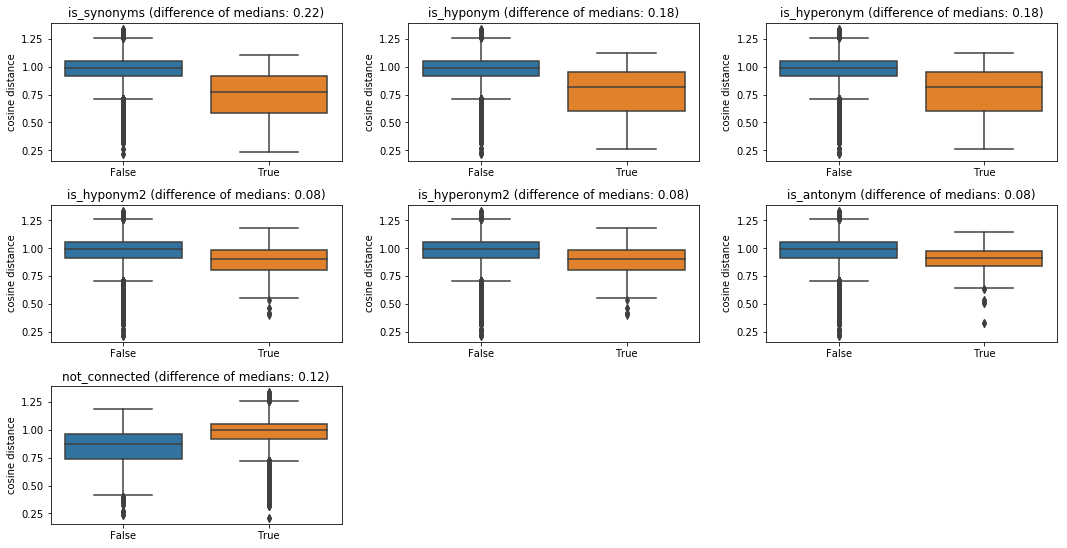

In [54]:
plt.figure(figsize=(15,10))
for idx, f in enumerate(dists_ds.drop(['w1','w2','dist'],1).columns):
    plt.subplot(dists_ds.shape[1]//3+1,3,idx+1)
    sns.boxplot(x=f, y='dist', data=dists_ds)
    md = abs(dists_ds[dists_ds[f]==True]['dist'].median()-dists_ds[dists_ds[f]==False]['dist'].median())
    plt.title(f"{f} (difference of medians: {md:.2f})")
    plt.xlabel('')
    plt.ylabel('cosine distance')
plt.tight_layout()
plt.show()

### Вывод 1
Расстояние между связанными словами меньше, чем между несвязанными. 

# Гипотеза 2

Может быть есть векторы "синонимичности", "гипонимичности" и т.д.?

Для этого сравним векторы разностей для синонимов, антонимов и т.п. Если векторы разностей синонимов будут похожи между собой, значит можно сказать, что существуют особые "векторы синонимичности".

Сначала рассчитаем косинусные расстояния между векторами разностей связанных слов. Для каждого типа связи случайным образом выберем 100 пар слов, чтобы можно было сравнивать доверительные интервалы для разных типов связей.

In [55]:
wvs_diffs_pair_dicts = {}
for idx, f in tqdm(enumerate(dists_ds.drop(['w1','w2','dist'],1).columns), total=len(dists_ds.columns)-3):
    cds = dists_ds[dists_ds[f]].sample(100)
    wvs_diffs_dict = {}
    for w1, w2 in cds[['w1','w2']].values:
        wvs_diffs_dict[(w1,w2)] = wvs_dict[w1]-wvs_dict[w2]
        
    d = {}
    for w_diff1, diff_1 in tqdm(wvs_diffs_dict.items(), total=len(wvs_diffs_dict), desc=f):
        for w_diff2, diff_2 in tqdm(wvs_diffs_dict.items(), total=len(wvs_diffs_dict), leave=False, disable=True):
            if w_diff1==w_diff2:
                continue
            d[(w_diff1, w_diff2)] = cosine_distances([diff_1, diff_2])[0,1]
        
    wvs_diffs_pair_dicts[f] = d

Объединим результаты в единый датасет

In [56]:
dists_pair_ds = []
for k, pair_dict in wvs_diffs_pair_dicts.items():
    cds = pd.Series(pair_dict).reset_index().rename(columns={'level_0':'pair 0', 'level_1':'pair 1', 0:'dist'})
    cds['type'] = k
    dists_pair_ds.append(cds)

dists_pair_ds = pd.concat(dists_pair_ds)

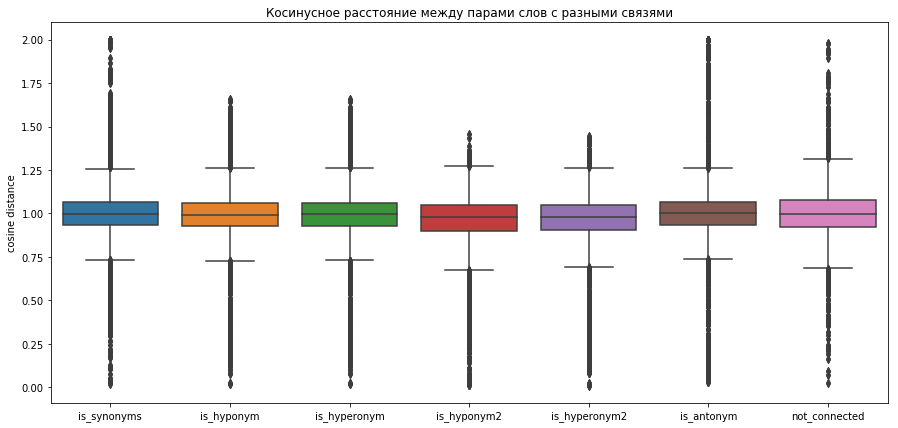

In [58]:
plt.figure(figsize=(15,7))
sns.boxplot(x='type', y='dist', data=dists_pair_ds)
plt.xlabel('')
plt.ylabel('cosine distance')
plt.title('Косинусное расстояние между парами слов с разными связями')
plt.show()

### Вывод 2
Не существует абстракного вектора "синонимии", "гипонимии" и т.п.

# Гипотеза 3

Может быть векторы "гипонимии" и т.п. существуют хотя бы в разрезе каждого конкретного слова?

Выделим пары, с совпадающими словами. Для этого сначала выделим все слова в парах

In [73]:
dists_pair_ds['word 0'] = [p[0] for p in dists_pair_ds['pair 0']]
dists_pair_ds['word 1'] = [p[1] for p in dists_pair_ds['pair 0']]
dists_pair_ds['word 2'] = [p[0] for p in dists_pair_ds['pair 1']]
dists_pair_ds['word 3'] = [p[1] for p in dists_pair_ds['pair 1']]

Выделим пары, в которых совпадает хотя бы одно слово

In [74]:
fs = []
for w0 in ['word 0','word 1','word 2','word 3']:
    for w1 in ['word 0','word 1','word 2','word 3']:
        if w0==w1:
            continue
            
        dists_pair_ds[f"{w0}=={w1}"] = dists_pair_ds[w0]==dists_pair_ds[w1]
        fs.append(f"{w0}=={w1}")

dists_pair_ds['has_common_word'] = dists_pair_ds[fs].any(1)
dists_pair_ds = dists_pair_ds.drop(fs,1)

Выделим пары, в которых совпадает первое или последнее слова

In [75]:
dists_pair_ds['has_same_first_word'] = dists_pair_ds['word 0']==dists_pair_ds['word 2']
dists_pair_ds['has_same_last_word'] = dists_pair_ds['word 1']==dists_pair_ds['word 3']

In [76]:
dists_pair_ds[['has_common_word','has_same_first_word', 'has_same_last_word']].sum()

has_common_word        4792
has_same_first_word    1510
has_same_last_word     1412
dtype: int64

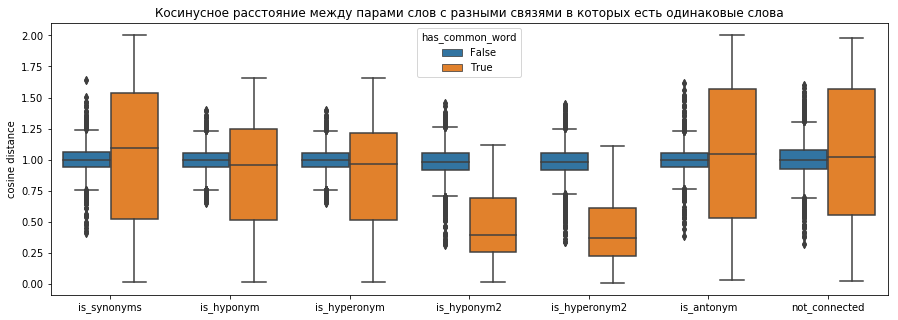

In [77]:
plt.figure(figsize=(15,5))
sns.boxplot(x='type', y='dist', hue='has_common_word', data=dists_pair_ds)
plt.xlabel('')
plt.ylabel('cosine distance')
plt.title('Косинусное расстояние между парами слов с разными связями в которых есть одинаковые слова')
plt.show()

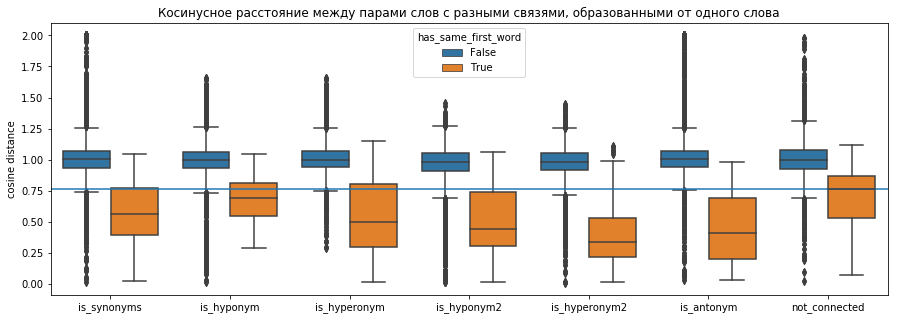

In [78]:
plt.figure(figsize=(15,5))
sns.boxplot(x='type', y='dist', hue='has_same_first_word', data=dists_pair_ds)
m = dists_pair_ds[(dists_pair_ds['type']=='not_connected')&(dists_pair_ds['has_same_first_word'])]['dist'].median()
plt.axhline(m, label=f'median of not connected, same first word pairs: {m:.2f}')
plt.xlabel('')
plt.ylabel('cosine distance')
plt.title('Косинусное расстояние между парами слов с разными связями, образованными от одного слова')
plt.show()

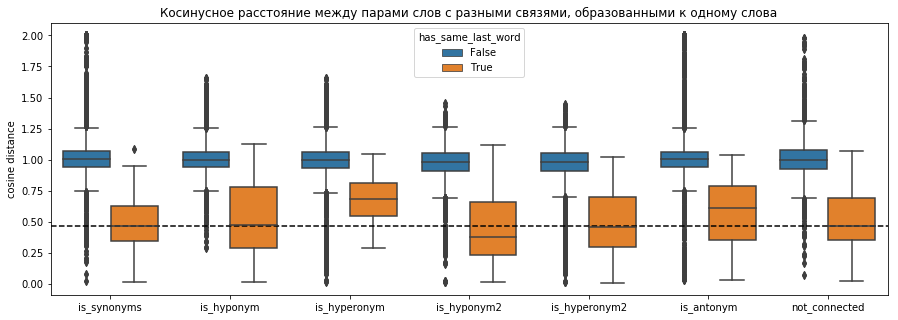

In [79]:
plt.figure(figsize=(15,5))
sns.boxplot(x='type', y='dist', hue='has_same_last_word', data=dists_pair_ds)
m = dists_pair_ds[(dists_pair_ds['type']=='not_connected')&(dists_pair_ds['has_same_last_word'])]['dist'].median()
plt.axhline(m, label=f'median of not connected, same last word pairs: {m:.2f}', color='black', linestyle='--')
plt.xlabel('')
plt.ylabel('cosine distance')
plt.title('Косинусное расстояние между парами слов с разными связями, образованными к одному слова')
plt.show()

### Вывод 3

Пары слов, синонимичных к одному и тому же слову, похожи друг на друга. Однако настолько же похожи и любые другие две пары, в которых содержатся одинаковые слова. Таким образом, нельзя сказать, что существуют векторы "антонимичности", "синонимичности", "гипонимии", "гиперонимии".

# Гипотеза 4

Может быть на векторах слов хотя работают алгебраические зависимости?

## Стандартный пример
Для начала рассмотрим известный пример с королем и королевой
* король-королева ~= муж-жена
* король ~= муж - жена + королева
* муж ~= король - королева + жена

In [80]:
model.similar_by_vector((model.wv['муж_NOUN']-model.wv['жена_NOUN']) + model.wv['королева_NOUN'])

/home/egor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
/home/egor/.local/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('королева_NOUN', 0.9201189279556274),
 ('королева_ADV', 0.7500719428062439),
 ('королева_ADJ', 0.6821377277374268),
 ('принцесса_NOUN', 0.6805639863014221),
 ('королева_PROPN', 0.6683740615844727),
 ('герцогиня_NOUN', 0.6672440767288208),
 ('мазарини_PROPN', 0.6401978731155396),
 ('мария::стюарт_PROPN', 0.6162000894546509),
 ('вальер_PROPN', 0.6161676645278931),
 ('фаворитка_NOUN', 0.6091272830963135)]

In [81]:
print(pd.DataFrame(model.similar_by_vector((model.wv['муж_NOUN']-model.wv['жена_NOUN']) + model.wv['королева_NOUN'])).to_latex())

\begin{tabular}{llr}
\toprule
{} &                    0 &         1 \\
\midrule
0 &        королева\_NOUN &  0.920119 \\
1 &         королева\_ADV &  0.750072 \\
2 &         королева\_ADJ &  0.682138 \\
3 &       принцесса\_NOUN &  0.680564 \\
4 &       королева\_PROPN &  0.668374 \\
5 &       герцогиня\_NOUN &  0.667244 \\
6 &       мазарини\_PROPN &  0.640198 \\
7 &  мария::стюарт\_PROPN &  0.616200 \\
8 &         вальер\_PROPN &  0.616168 \\
9 &       фаворитка\_NOUN &  0.609127 \\
\bottomrule
\end{tabular}



/home/egor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


Предполагалось, что результатом окажется вектор, похожий на короля (или что-то из королевской тематики мужского рода) но результат оказался другим.

In [82]:
print(pd.DataFrame(model.similar_by_vector((model.wv['король_NOUN']-model.wv['королева_NOUN']) + model.wv['жена_NOUN'])).to_latex())

\begin{tabular}{llr}
\toprule
{} &               0 &         1 \\
\midrule
0 &       жена\_NOUN &  0.729585 \\
1 &       зять\_NOUN &  0.658955 \\
2 &      тесть\_NOUN &  0.609647 \\
3 &        муж\_NOUN &  0.580768 \\
4 &        сын\_NOUN &  0.564723 \\
5 &    супруга\_NOUN &  0.550519 \\
6 &        жена\_ADJ &  0.529578 \\
7 &       зять\_VERB &  0.523330 \\
8 &       отец\_NOUN &  0.522891 \\
9 &  племянник\_NOUN &  0.514432 \\
\bottomrule
\end{tabular}



/home/egor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


В этом случае наиболее похожим словом должен был оказаться "муж". Он только на 4ом месте. Однако большую часть похожий слов занимают члены семьи мужского рода, что тоже неплохо.

## 2 наиболее похожие пары слов

In [83]:
dists_pair_ds.sort_values('dist').head(5)

,pair 0,pair 1,dist,type,word 0,word 1,word 2,word 3,has_common_word,has_same_first_word,has_same_last_word
9672,"(определить, анализ)","(осмотреть, анализ)",0.009818,is_hyperonym2,определить,анализ,осмотреть,анализ,True,False,True
6927,"(осмотреть, анализ)","(определить, анализ)",0.009818,is_hyperonym2,осмотреть,анализ,определить,анализ,True,False,True
108,"(подобрать, пытаться)","(набрать, пытаться)",0.011190,is_hyponym2,подобрать,пытаться,набрать,пытаться,True,False,True
991,"(набрать, пытаться)","(подобрать, пытаться)",0.011190,is_hyponym2,набрать,пытаться,подобрать,пытаться,True,False,True
984,"(любоваться, определить)","(любоваться, выяснить)",0.011389,is_hyponym2,любоваться,определить,любоваться,выяснить,True,True,False


Разницы пары (выяснить, экспертиза), (определить, экспертиза) очень похожи друг на друга. Проверим на них алгебраические зависимости

* выяснить - экспертиза ~= определить - экспертиза
* выяснить ~= опредить - экспретиза + экспертиза ~= определить

Если алгебраические зависимости выполняются, то слово "выяснить" очень похоже на слово "определить". Так ли это?

In [84]:
dists_ds[(dists_ds['w1']=='выяснить')&(dists_ds['w2']=='определить')]

,w1,w2,dist,is_synonyms,is_hyponym,is_hyperonym,is_hyponym2,is_hyperonym2,is_antonym,not_connected
12744,выяснить,определить,0.831424,False,False,False,False,False,False,True


Не так. Векторы слов сильно различаются

Тогда почему эти слова имеют похожую разность векторов? Вероятно эти пары одинакого часто встречаются в текстах: когда кто-то провёл экспертизу и выяснил что-то или провёл экспертизу и определил что-то.

In [85]:
cosine_distances([wvs_dict['выяснить']-wvs_dict['экспертиза']], [wvs_dict['определить']-wvs_dict['экспертиза']])

array([[0.00725359]], dtype=float32)

## Похожие пары синонимов

Будем искать похожие пары среди тех, в которых ни одно слово не совпадает. Тогда слова не "сократятся" как в прошлом примере

In [86]:
dists_pair_ds[(dists_pair_ds['type']=='is_synonyms')&(~dists_pair_ds['has_common_word'])].sort_values('dist').head(10)

,pair 0,pair 1,dist,type,word 0,word 1,word 2,word 3,has_common_word,has_same_first_word,has_same_last_word
8067,"(собрать, напрячь)","(поднажать, напрягать)",0.405273,is_synonyms,собрать,напрячь,поднажать,напрягать,False,False,False
4832,"(поднажать, напрягать)","(собрать, напрячь)",0.405273,is_synonyms,поднажать,напрягать,собрать,напрячь,False,False,False
6285,"(собирать, напрячь)","(поднажать, напрягать)",0.426604,is_synonyms,собирать,напрячь,поднажать,напрягать,False,False,False
4814,"(поднажать, напрягать)","(собирать, напрячь)",0.426604,is_synonyms,поднажать,напрягать,собирать,напрячь,False,False,False
8380,"(старуха, бабуся)","(бабка, бабуля)",0.446799,is_synonyms,старуха,бабуся,бабка,бабуля,False,False,False
6419,"(бабка, бабуля)","(старуха, бабуся)",0.446799,is_synonyms,бабка,бабуля,старуха,бабуся,False,False,False
1156,"(препятствовать, мешать)","(воспрепятствовать, смешать)",0.474023,is_synonyms,препятствовать,мешать,воспрепятствовать,смешать,False,False,False
6743,"(воспрепятствовать, смешать)","(препятствовать, мешать)",0.474023,is_synonyms,воспрепятствовать,смешать,препятствовать,мешать,False,False,False
5003,"(бабулька, старуха)","(бабуся, бабка)",0.479916,is_synonyms,бабулька,старуха,бабуся,бабка,False,False,False
5396,"(бабуся, бабка)","(бабулька, старуха)",0.479916,is_synonyms,бабуся,бабка,бабулька,старуха,False,False,False


In [68]:
print(pd.DataFrame(model.similar_by_vector(wvs_dict['старуха']-wvs_dict['бабулька']+wvs_dict['бабуля'])).to_latex())

\begin{tabular}{llr}
\toprule
{} &                0 &         1 \\
\midrule
0 &     старуха\_NOUN &  0.926507 \\
1 &    старушка\_NOUN &  0.775208 \\
2 &       бабка\_NOUN &  0.762171 \\
3 &     бабушка\_NOUN &  0.707106 \\
4 &       тетка\_NOUN &  0.692906 \\
5 &  старушонка\_NOUN &  0.691257 \\
6 &      старик\_NOUN &  0.681647 \\
7 &     агафья\_PROPN &  0.647350 \\
8 &     соседка\_NOUN &  0.638528 \\
9 &    лукерья\_PROPN &  0.631201 \\
\bottomrule
\end{tabular}



Можно сказать, что модель учитывает "анти уменьшительно-ласкательные" отношения и делать слова более грубыми.

## Похожие связи между антонимами

In [51]:
dists_pair_ds[(dists_pair_ds['type']=='is_antonym')&(~dists_pair_ds['has_common_word'])].sort_values('dist').head(10)

,pair 0,pair 1,dist,type,word 0,word 1,word 2,word 3,has_common_word,has_same_first_word,has_same_last_word
3416,"(мастер, неспециалист)","(умелец, неумеха)",0.511308,is_antonym,мастер,неспециалист,умелец,неумеха,False,False,False
5083,"(умелец, неумеха)","(мастер, неспециалист)",0.511308,is_antonym,умелец,неумеха,мастер,неспециалист,False,False,False
3653,"(напрячь, надеть)","(напрягать, разбросать)",0.534249,is_antonym,напрячь,надеть,напрягать,разбросать,False,False,False
8946,"(напрягать, разбросать)","(напрячь, надеть)",0.534249,is_antonym,напрягать,разбросать,напрячь,надеть,False,False,False
7731,"(промотать, напрячь)","(растащить, напрягать)",0.539991,is_antonym,промотать,напрячь,растащить,напрягать,False,False,False
968,"(растащить, напрягать)","(промотать, напрячь)",0.539991,is_antonym,растащить,напрягать,промотать,напрячь,False,False,False
4049,"(напрячь, назначить)","(напрягать, разбросать)",0.560575,is_antonym,напрячь,назначить,напрягать,разбросать,False,False,False
8950,"(напрягать, разбросать)","(напрячь, назначить)",0.560575,is_antonym,напрягать,разбросать,напрячь,назначить,False,False,False
7560,"(напрягать, растащить)","(напрячь, надеть)",0.565420,is_antonym,напрягать,растащить,напрячь,надеть,False,False,False
3639,"(напрячь, надеть)","(напрягать, растащить)",0.565420,is_antonym,напрячь,надеть,напрягать,растащить,False,False,False


In [52]:
model.similar_by_vector(wvs_dict['неспециалист']-wvs_dict['мастер']+wvs_dict['умелец'], 20)

[('неспециалист_NOUN', 0.36014968156814575),
 ('умелец_NOUN', 0.31775686144828796),
 ('вездеход_NOUN', 0.30166056752204895),
 ('съедобный_ADJ', 0.30121636390686035),
 ('лазера_NOUN', 0.29404670000076294),
 ('гош_PROPN', 0.2931995391845703),
 ('толком_ADV', 0.2927326560020447),
 ('череп_PROPN', 0.2890816628932953),
 ('приборчик_NOUN', 0.28903481364250183),
 ('гуманоид_NOUN', 0.2870415151119232),
 ('поверье_NOUN', 0.28493401408195496),
 ('сейд_NOUN', 0.2792907953262329),
 ('глушилка_NOUN', 0.27564871311187744),
 ('псих_NOUN', 0.2756391763687134),
 ('наверняка_ADV', 0.27538782358169556),
 ('абориген_NOUN', 0.27505677938461304),
 ('штуковина_NOUN', 0.2736056447029114),
 ('экстрасенс_NOUN', 0.26838284730911255),
 ('холодильник_NOUN', 0.266996294260025),
 ('пиранье_NOUN', 0.2655104994773865)]

В качестве ответа должен был получиться кто-то с плохой компетенцией. Но этого не оказалось.

In [53]:
model.similar_by_vector(wvs_dict['мастерица']-wvs_dict['неспециалист']+wvs_dict['дилетант'], 20)

[('мастерица_NOUN', 0.8040676116943359),
 ('рукодельница_NOUN', 0.5702055096626282),
 ('дилетант_NOUN', 0.5388522148132324),
 ('искусница_NOUN', 0.5231117010116577),
 ('любительница_NOUN', 0.5011034607887268),
 ('мастер_NOUN', 0.49565428495407104),
 ('швея_NOUN', 0.474587082862854),
 ('швь_NOUN', 0.47264033555984497),
 ('музыкантша_NOUN', 0.46468493342399597),
 ('виртуоза_NOUN', 0.45768722891807556),
 ('портниха_NOUN', 0.45756667852401733),
 ('искусник_NOUN', 0.4564761221408844),
 ('виртуоз_NOUN', 0.4555569589138031),
 ('мастериец_NOUN', 0.4539269208908081),
 ('вышивальщица_NOUN', 0.4529009461402893),
 ('кокетка_NOUN', 0.4479062557220459),
 ('портретист_NOUN', 0.4455658793449402),
 ('белошвейный_ADJ', 0.44065290689468384),
 ('кружевница_NOUN', 0.44025087356567383),
 ('охотница_NOUN', 0.43736350536346436)]

В этом случае должен был получиться кто-то с хорошей компетенцией. И правда: "искусница", "мастер", "виртуоза" - опытные люди.

# Итого

Данная модель Word2Vec на базе подхода CBOW, не определяет семантические зависимости между словами. В частности: синонимию, антонимию, гиперонимию, гипонимию. 

Интересно, что наиболее похожи друг на друга слова, являющиеся гипонимами гипонимов. Скорее всего такие слова просто часто встречаются в тексте рядом друг с другом, так как они одновременно обозначают и похожие и слегка различные понятия и действия.

Иногда можно заметить, будто модель улавливает различия между грубыми и негрубыми словами, будто она видит разницу между компетентными и некомпетентными людьми. Однако это похоже на исключения из правил. А также похоже на результат проверки множества гипотез: если очень сильно искать моделируемые сложные зависимости, то обязательно можно что-нибудь найти.